# This notebook contains preliminary results

In [ ]:
%load_ext autoreload
%autoreload 2 
%matplotlib inline

# Set path to find modelling tools for later use
import os
import sys
sys.path.append(os.path.join(os.getcwd(),".."))

from pathlib import Path
from haberrspd.__init_paths import data_root
from haberrspd.preprocess_baseline import (create_mjff_baselines,
                                           reference_sentences,
                                           calculate_iki_and_ed_baseline,
                                           calculate_all_baseline_ROC_curves,
                                           convert_df_to_subject_level,
                                           test_different_splits_for_classification)

from haberrspd.plotting import plot_roc_curve_simple, plot_superimposed_roc_curves, nice_fonts
import pandas as pd
import numpy as np

# Plot stuff
import seaborn as sns
from scipy.constants import golden
import matplotlib as mpl
import matplotlib.pyplot as plt


# Settings for plotting

# plt.style.use('dark_background')
# Set to default again
# plt.rcParams.update(plt.rcParamsDefault)
# mpl.rcParams.update(nice_fonts)

# Baseline classifiers

## MJFF [sentence level]

In [ ]:
# Load data
df = pd.read_csv(data_root / 'MJFF' / 'raw' / 'EnglishData-duplicateeventsremoved.csv')
df_meta = pd.read_csv(data_root / 'MJFF' / 'raw' / 'EnglishParticipantKey.csv',
                      header=0,
                      names=["participant_id", "ID", "attempt", "diagnosis"],
                     )

In [ ]:
which_attempt = 1

df_baselines_raw = create_mjff_baselines(df,df_meta,
                                         attempt=which_attempt,
                                         invokation_type=-1) # No changes have been made
df_baselines_edited = create_mjff_baselines(df,df_meta,
                                            attempt=which_attempt,
                                            invokation_type=1) # Error corrections have been made

print(df_baselines_raw.edit_distance.var())
print(df_baselines_edited.edit_distance.var())

out1 = calculate_all_baseline_ROC_curves(df_baselines_raw)
out2 = calculate_all_baseline_ROC_curves(df_baselines_edited)

In [ ]:
plot_superimposed_roc_curves([out1,out2],
                             'mjff_attempt_' + str(which_attempt) +'_sentence_level_rfc')

## MRC [sentence level]

In [66]:
df1 = pd.read_pickle(Path('../data/MRC/') / 'processed_mcr.pkl')
df2 = df1.copy(deep=True)

#### With dropped shift

In [67]:
df_baselines_raw = calculate_iki_and_ed_baseline(df1, 
                                                 drop_shift=True, 
                                                 invokation_type=-1) # No changes have been made
df_baselines_edited = calculate_iki_and_ed_baseline(df2, 
                                                    drop_shift=True, 
                                                    invokation_type=1) # Error corrections have been made

print(df_baselines_raw.Edit_Distance.var())
print(df_baselines_edited.Edit_Distance.var())


 Number of shift-rows dropped: 17239

 Number of shift-rows dropped: 17239
1907.5331913198593
1769.7588341689618


In [68]:
out1 = calculate_all_baseline_ROC_curves(df_baselines_raw)
out2 = calculate_all_baseline_ROC_curves(df_baselines_edited)

In [69]:
out2["III"] = out2.pop("I")
out2["IV"] = out2.pop("II")
data = {**out1, **out2}

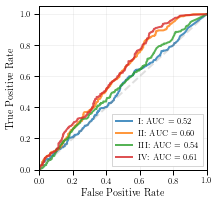

In [70]:
plot_superimposed_roc_curves(data,'mrc_baseline_dropped_shift_sentence_level')

#### With kept shift

In [ ]:
df_baselines_raw = calculate_iki_and_ed_baseline(df1, 
                                                 drop_shift=False, 
                                                 invokation_type=-1) # No changes have been made
df_baselines_edited = calculate_iki_and_ed_baseline(df2, 
                                                    drop_shift=False,
                                                    invokation_type=1) # Error corrections have been made

print(df_baselines_raw.Edit_Distance.var())
print(df_baselines_edited.Edit_Distance.var())

In [61]:
a = calculate_all_baseline_ROC_curves(df_baselines_raw)
b = calculate_all_baseline_ROC_curves(df_baselines_edited)

In [62]:
b["III"] = b.pop("I")
b["IV"] = b.pop("II")
data = {**a, **b}

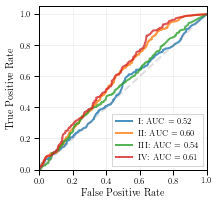

In [65]:
# plot_superimposed_roc_curves(data)
new_plot_superimposed_roc_curves(data,'mrc_baseline_sentence_level')

In [64]:
from haberrspd.plotting import nice_fonts
from sklearn.metrics import auc, roc_curve
import datetime
from sklearn.preprocessing import label_binarize
def new_plot_superimposed_roc_curves(data: dict, filename=None) -> None:

    # Set styles for paper
    sns.set_context("paper")
    mpl.rcParams.update(nice_fonts)

    lw = 2
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    palette = sns.color_palette(n_colors=len(data))
    for i, item in enumerate(data.keys()):
        y_true, y_scores = data[item]
        # Main calculations here
        fpr, tpr, _ = roc_curve(y_true, y_scores, pos_label=1)
        # Calculate area under the ROC curve here
        auc = np.trapz(tpr, fpr)
        ax.plot(fpr, tpr, color=palette[i], lw=lw, alpha=0.8, label="%s: AUC = %0.2f" % (item, auc))

    ax.plot([0, 1], [0, 1], color="gray", lw=lw, linestyle="--", alpha=0.25)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    # Legend
    ax.legend(loc="lower right", ncol=1, framealpha=1, fancybox=False, borderpad=0.5)
    # Grid
    ax.grid(True, alpha=0.2)

    if filename:
        # Set reference time for save
        now = datetime.datetime.now()
        fig.savefig(
            "../figures/baseline_roc_curves-" + filename + "-" + now.strftime("%Y-%m-%d-%H:%M") + ".pdf",
            bbox_inches="tight",
        )
    else:
        plt.show()

### MJFF [subject level]

In [ ]:
df_baselines_raw.head()

In [ ]:
for i in [df_baselines_raw, df_baselines_edited]:
    outs = get_X_and_y_from_df(convert_df_to_subject_level(i))
    for j in ['I','II']:
        print(j,test_different_splits_for_classification(outs[j]))

### MRC [sentence level]

In [ ]:
f = processMRC()

In [ ]:
f()

# Modelling CHARACTERS ('char') only

This commences the CNN approach to the task.

In [ ]:
char = {100 : np.genfromtxt('../results/char/label_and_label_probs_2019-07-30_16-03-33.csv', delimiter=','), 
        200 : np.genfromtxt('../results/char/label_and_label_probs_2019-07-30_16-37-21.csv', delimiter=','), 
        500 : np.genfromtxt('../results/char/label_and_label_probs_2019-07-30_17-46-29.csv', delimiter=',')}

In [ ]:
for key in char.keys():
    print("Number of hyperparameter permutations considered: {}\n".format(key))
    plot_roc_curve_simple(char[key][:,0].astype(np.int64), char[key][:,1])

In [ ]:
plot_roc_curve_simple(char[200][:,0].astype(np.int64), char[200][:,1],'mjff_char_only')

# CHARACTERS and TIME

In [ ]:
char_time = {100 : np.genfromtxt('../results/char_time/label_and_label_probs_2019-07-26_21-25-18.csv', delimiter=','), 
 200 : np.genfromtxt('../results/char_time/label_and_label_probs_2019-07-26_15-00-06.csv', delimiter=','), 
 500 : np.genfromtxt('../results/char_time/label_and_label_probs_2019-07-26_12-24-09.csv', delimiter=',')}

In [ ]:
for key in char_time.keys():
    print("Number of hyperparameter permutations considered: {}\n".format(key))
    plot_roc_curve_simple(char_time[key][:,0].astype(np.int64), char_time[key][:,1])

In [ ]:
plot_roc_curve_simple(char_time[200][:,0].astype(np.int64), char_time[200][:,1],'mjff_char_time')

# CHARACTERS and TIME and Space

In [ ]:
char_time_space = {100 : np.genfromtxt('../results/char_time_space/label_and_label_probs_2019-07-30_15-46-27.csv', delimiter=','), 
                   500 : np.genfromtxt('../results/char_time_space/label_and_label_probs_2019-07-30_21-34-27.csv', delimiter=',')}

In [ ]:
for key in char_time_space.keys():
    print("Number of hyperparameter permutations considered: {}\n".format(key))
    plot_roc_curve_simple(char_time_space[key][:,0].astype(np.int64), char_time_space[key][:,1])

In [ ]:
plot_roc_curve_simple(char_time_space[500][:,0].astype(np.int64), char_time_space[500][:,1],'mjff_char_time_space')

In [ ]:
# Check the details of the best model for one of the optimisations
df = pd.read_csv("../results/char_time_space/073019144454.csv")

In [ ]:
# Sort by validation accuracy
df.sort_values(by=['val_acc'],ascending=False).head(10)

In [ ]:
# Detailed look at the "winning model"
df.iloc[387,:]